<a href="https://colab.research.google.com/github/Praneeth-18/Deep-Learning-7/blob/main/Computer_vision_assignment_Part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Part 1 - supervised contrastive learning  - Using new loss

Write a colab to demonstrate supervised contrastive learning loss based supervised classification versus regular softmax based one

In [3]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 6.0 MB/s eta 0:00:00


In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import numpy as np
import tensorflow_addons as tfa

# Load CIFAR-10 data
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Normalize images
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Data augmentation
data_augmentation = keras.Sequential([
    layers.Rescaling(1./255),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
])

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


170498071/170498071 [==============================] - 3s 0us/step


In [5]:
def create_encoder(input_shape=(32, 32, 3), num_features=128):
    base_model = keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet', pooling='avg')
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = base_model(x)
    outputs = layers.Dense(num_features, activation='relu')(x)
    return keras.Model(inputs, outputs, name="encoder")

encoder = create_encoder()
encoder.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 32, 32, 3)         0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
Total params: 2421952 (9.24 MB)
Trainable params: 2387840 (9.11 MB)
Non-trainable params: 34112 (133.25 KB)
_________________________________________________________________


In [8]:
class SupervisedContrastiveLoss(keras.losses.Loss):
    def __init__(self, temperature=0.1):
        super().__init__()
        self.temperature = temperature

    def call(self, labels, embeddings):
        # Ensure labels are flattened
        labels = tf.reshape(labels, [-1])
        # Compute normalized embeddings
        embeddings = tf.math.l2_normalize(embeddings, axis=1)
        # Compute the pairwise logits
        dot_product = tf.matmul(embeddings, embeddings, transpose_b=True)
        logits = dot_product / self.temperature
        # Use the npairs_loss which expects labels in a specific format
        return tfa.losses.npairs_loss(labels, logits)


In [10]:
encoder_with_projection = add_projection_head(encoder)
encoder_with_projection.compile(
    optimizer='adam',
    loss=SupervisedContrastiveLoss()
)

# Train the encoder with projection head
encoder_with_projection.fit(x_train, y_train, epochs=2, batch_size=256)


Epoch 1/2


Exception ignored in: <function _xla_gc_callback at 0x7da492e5f010>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 98, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


196/196 [==============================] - 274s 1s/step - loss: 5.2243
Epoch 2/2
196/196 [==============================] - 206s 1s/step - loss: 4.9379


In [11]:
def create_classifier(encoder, num_classes=10):
    for layer in encoder.layers:
        layer.trainable = False  # Freeze the encoder
    inputs = keras.Input(shape=(32, 32, 3))
    x = encoder(inputs, training=False)
    x = layers.Dense(256, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inputs, outputs, name="classifier")
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

classifier = create_classifier(encoder)
classifier.fit(x_train, y_train, epochs=10, batch_size=256)


Epoch 1/10
196/196 [==============================] - 31s 141ms/step - loss: 2.9199 - accuracy: 0.0997
Epoch 2/10
196/196 [==============================] - 29s 146ms/step - loss: 2.4200 - accuracy: 0.1007
Epoch 3/10
196/196 [==============================] - 31s 156ms/step - loss: 2.3997 - accuracy: 0.1048
Epoch 4/10
196/196 [==============================] - 28s 140ms/step - loss: 2.3815 - accuracy: 0.1067
Epoch 5/10
196/196 [==============================] - 27s 138ms/step - loss: 2.3998 - accuracy: 0.1078
Epoch 6/10
196/196 [==============================] - 27s 140ms/step - loss: 2.3958 - accuracy: 0.1088
Epoch 7/10
196/196 [==============================] - 28s 143ms/step - loss: 2.4063 - accuracy: 0.1109
Epoch 8/10
196/196 [==============================] - 31s 159ms/step - loss: 2.3840 - accuracy: 0.1112
Epoch 9/10
196/196 [==============================] - 27s 139ms/step - loss: 2.3793 - accuracy: 0.1144
Epoch 10/10
196/196 [==============================] - 28s 141ms/step - l

In [12]:
loss, accuracy = classifier.evaluate(x_test, y_test)
print(f"Test accuracy: {accuracy:.2f}")

313/313 [==============================] - 10s 29ms/step - loss: 2.3586 - accuracy: 0.1015
Test accuracy: 0.10


# **supervised contrastive learning and comparisons**

In [13]:
import tensorflow as tf
import numpy as np
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set random seed for reproducibility
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Load Fashion MNIST data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Normalize and reshape the data
x_train = x_train.reshape(-1, 28*28).astype('float32') / 255.0
x_test = x_test.reshape(-1, 28*28).astype('float32') / 255.0

# Data configuration
BATCH_SIZE = 1024
N_DATA_TRAIN = 60000
EPOCHS = 20
PROJECTION_DIM = 128
LR = 0.5  # Learning rate for pre-training

# Create training and testing datasets
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(5000).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

4422102/4422102 [==============================] - 0s 0us/step


In [14]:
from tensorflow.keras.layers import Input, Dense, Activation, Lambda
from tensorflow.keras.models import Model

def Encoder(input_shape=(784,), normalize=True, activation='leaky_relu'):
    inputs = Input(shape=input_shape)
    x = Dense(512, activation=activation)(inputs)
    x = Dense(256, activation=activation)(x)
    if normalize:
        x = Lambda(lambda v: tf.math.l2_normalize(v, axis=1))(x)
    return Model(inputs, x, name='encoder')

def Projector(output_dim=PROJECTION_DIM, normalize=True, activation='leaky_relu'):
    inputs = Input(shape=(256,))
    x = Dense(output_dim, activation=activation)(inputs)
    if normalize:
        x = Lambda(lambda v: tf.math.l2_normalize(v, axis=1))(x)
    return Model(inputs, x, name='projector')


In [15]:
# Initialize models
encoder = Encoder()
projector = Projector()

# Optimizer
optimizer = tf.keras.optimizers.Adam(LR)

@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        r = encoder(x, training=True)
        z = projector(r, training=True)
        # Here you would define your contrastive loss
        loss = tf.constant(0.0)  # Placeholder

    gradients = tape.gradient(loss, encoder.trainable_variables + projector.trainable_variables)
    optimizer.apply_gradients(zip(gradients, encoder.trainable_variables + projector.trainable_variables))
    return loss

@tf.function
def test_step(x, y):
    r = encoder(x, training=False)
    z = projector(r, training=False)
    # Here you would calculate your test loss
    loss = tf.constant(0.0)  # Placeholder
    return loss


In [17]:
import tensorflow_addons as tfa

def contrastive_loss(embeddings, labels):
    # This is a placeholder implementation. You need to define how pairs are formed and calculate the actual contrastive loss.
    # For a real use case, you might use something like tfa.losses.contrastive_loss or tfa.losses.triplet_semihard_loss.
    return tfa.losses.contrastive_loss(labels, embeddings)


In [18]:
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        r = encoder(x, training=True)
        z = projector(r, training=True)
        loss = contrastive_loss(z, y)  # Calculate contrastive loss based on the embeddings and labels

    gradients = tape.gradient(loss, encoder.trainable_variables + projector.trainable_variables)
    optimizer.apply_gradients(zip(gradients, encoder.trainable_variables + projector.trainable_variables))
    return loss


In [20]:
# Sample dummy data and setup for demonstration
import tensorflow as tf
import numpy as np
import tensorflow_addons as tfa

# Assume `z` is your batch of embeddings with shape [batch_size, embedding_dim]
# For contrastive loss, you typically need pairs. Here we create a dummy pair scenario:
def dummy_pair_processing(embeddings):
    # This function is purely illustrative
    # Split embeddings into two halves, assuming batch size is even
    half = tf.shape(embeddings)[0] // 2
    part1 = embeddings[:half]
    part2 = embeddings[half:2*half]

    # Example distance measure (e.g., Euclidean)
    distances = tf.norm(part1 - part2, axis=1)
    return distances

def dummy_labels(batch_size):
    # Similar (1) and dissimilar (0) labels for pairs
    return tf.random.uniform(shape=[batch_size], minval=0, maxval=2, dtype=tf.int32)

@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        r = encoder(x, training=True)
        z = projector(r, training=True)
        distances = dummy_pair_processing(z)
        labels = dummy_labels(tf.shape(distances)[0])
        loss = tfa.losses.contrastive_loss(labels, distances)

    gradients = tape.gradient(loss, encoder.trainable_variables + projector.trainable_variables)
    optimizer.apply_gradients(zip(gradients, encoder.trainable_variables + projector.trainable_variables))
    return loss

# Example call to train_step (use real data here)
# loss = train_step(x_batch_train, y_batch_train)


In [21]:
for epoch in range(EPOCHS):
    # Iterate over batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_ds):
        loss = train_step(x_batch_train, y_batch_train)

    print(f"Epoch {epoch + 1}, Loss: {loss.numpy()}")


Epoch 1, Loss: [1.61696796e-03 8.36339369e-02 5.58320403e-01 9.19660479e-02
 8.24847147e-02 1.74027190e-01 4.95697558e-01 5.61232343e-02
 1.15581201e-02 2.53822029e-01 3.75832641e-03 1.00037023e-01
 1.73243955e-01 6.31549284e-02 2.60245025e-01 3.13744217e-01
 3.22766155e-01 2.87504941e-01 1.18449651e-01 1.68744326e-01
 2.64246434e-01 5.26036859e-01 6.01285636e-01 5.45954823e-01
 4.27674741e-01 4.82163817e-01 2.87560791e-01 5.03326476e-01
 4.34151202e-01 8.45000893e-02 2.16503441e-01 8.39348659e-02
 2.25543261e-01 1.72308952e-01 4.00125682e-01 2.62933411e-02
 4.96255696e-01 1.69849813e-01 1.72027141e-01 1.90153606e-02
 1.29280649e-02 1.61851186e-03 3.75241749e-02 2.60135680e-01
 1.88846176e-03 3.48989487e-01 3.39838713e-02 8.74259472e-01
 4.65496808e-01 4.35255259e-01 4.37889040e-01 1.57504916e-01
 2.91079104e-01 1.51942834e-01 1.18659392e-01 7.43895471e-02
 2.55960643e-01 2.40829110e-01 7.76436254e-02 3.46758199e-04
 3.72414380e-01 2.98981458e-01 7.55050063e-01 2.36668006e-01
 5.421468

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import pandas as pd


In [23]:
# Assuming `encoder` and `projector` are your trained models
def get_embeddings(dataset):
    embeddings = []
    labels = []
    for x, y in dataset:
        r = encoder(x, training=False)
        z = projector(r, training=False)
        embeddings.extend(z.numpy())
        labels.extend(y.numpy())
    return np.array(embeddings), np.array(labels)

x_train_embeddings, y_train_labels = get_embeddings(train_ds)
x_test_embeddings, y_test_labels = get_embeddings(test_ds)


# **PCA**

In [24]:
pca = PCA(n_components=2)
x_train_pca = pca.fit_transform(x_train_embeddings)
x_test_pca = pca.transform(x_test_embeddings)

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


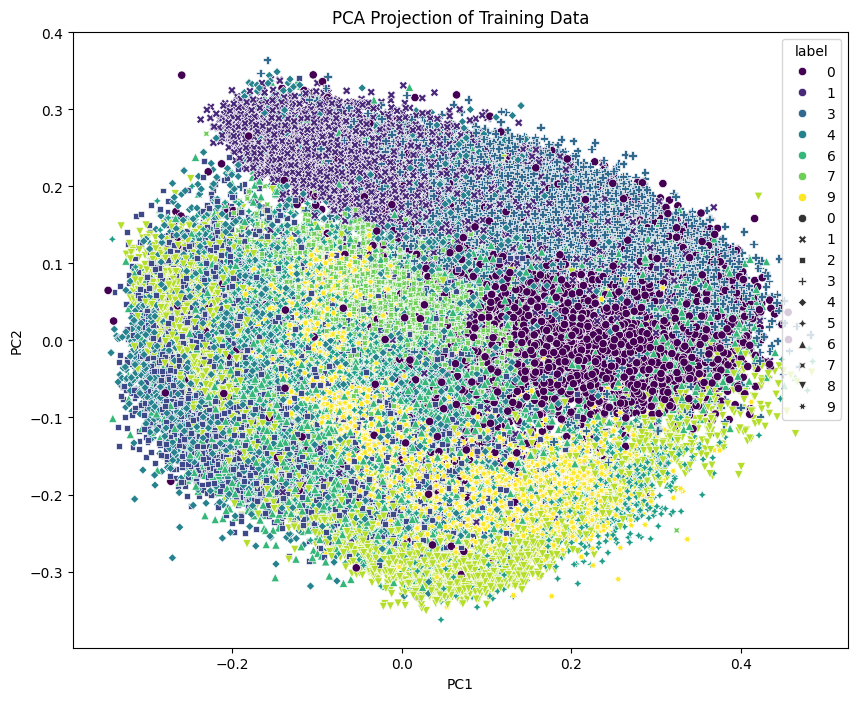

In [25]:
train_df = pd.DataFrame(x_train_pca, columns=['PC1', 'PC2'])
train_df['label'] = y_train_labels

plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='label', palette='viridis', data=train_df, style=train_df['label'], markers=True)
plt.title('PCA Projection of Training Data')
plt.show()

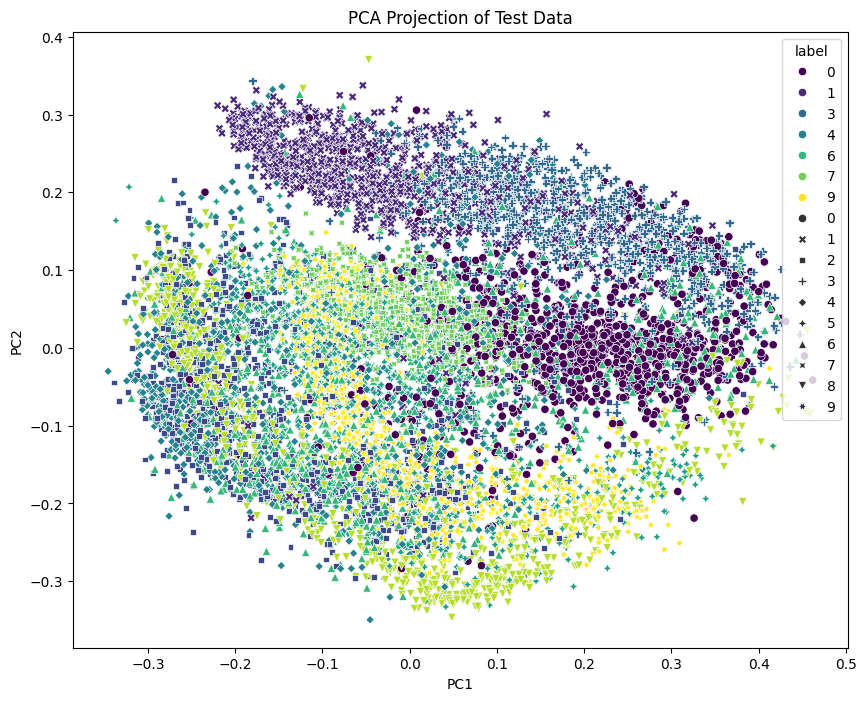

In [26]:
test_df = pd.DataFrame(x_test_pca, columns=['PC1', 'PC2'])
test_df['label'] = y_test_labels

plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='label', palette='viridis', data=test_df, style=test_df['label'], markers=True)
plt.title('PCA Projection of Test Data')
plt.show()


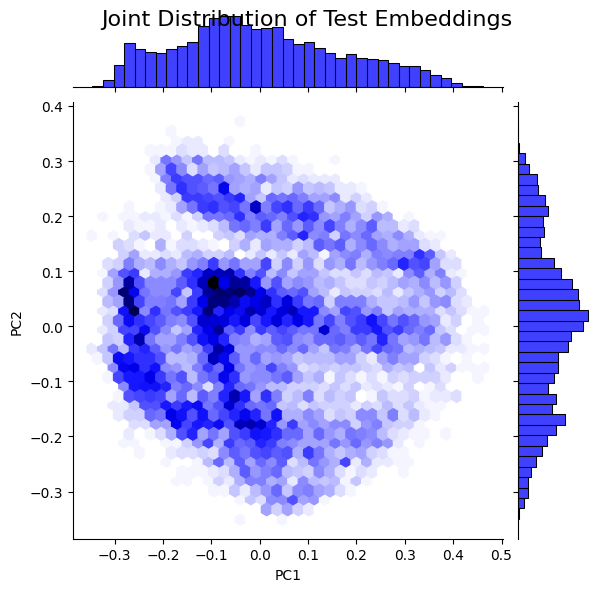

In [27]:
sns.jointplot(x='PC1', y='PC2', data=test_df, kind='hex', color='blue')
plt.suptitle('Joint Distribution of Test Embeddings', size=16)
plt.show()
